# Sto learning 


In [1]:
import matplotlib.pyplot as plt
import dgl
from torch.utils.data import DataLoader
import torch
import time
import os
import sys
sys.path.insert(0, "../lib/")
import laplacian
import ninja
import sys
import utils
import model
import graphs
from utils import set_device
from laplacian import normalized_laplacian


# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

device = set_device(verbose=True)

cuda available


# MNIST

In [2]:
# Downloads the dataset if not found locally
from mnist import check_mnist_dataset_exists, datasampler, MNISTDataset

_ = check_mnist_dataset_exists()

nb_selected_train_data = 60000
nb_selected_test_data = 10000

train_data, train_labels, test_data, test_labels = datasampler(
    nb_selected_train_data, nb_selected_test_data
)

trainset = MNISTDataset(train_data, train_labels, lattice_type=0)
testset = MNISTDataset(test_data, test_labels)

## Visualise the dataset

Label: tensor(2.)
graph: DGLGraph(num_nodes=784, num_edges=3024,
         ndata_schemes={}
         edata_schemes={})
Largest eigenvalue: (2.000000000000003+0j)
Smallest eigenvalue: (1.5543122344752192e-15+0j)


/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


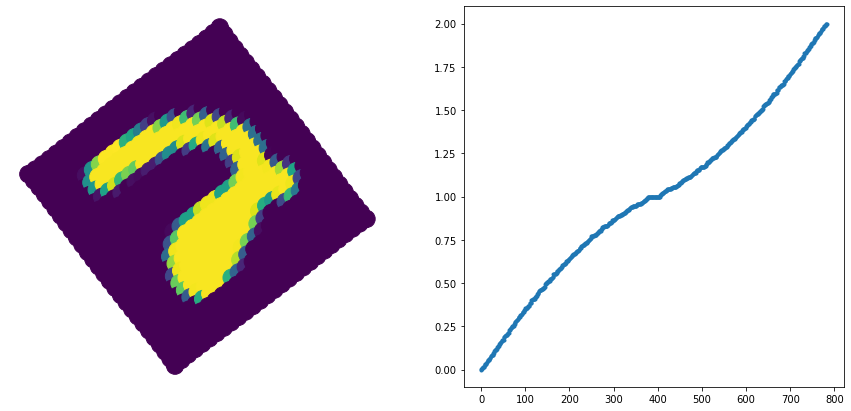

In [3]:
import networkx as nx
import random
from ninja import GeigplotL
plt.figure(figsize=(15,7))

plt.subplot(121)
g_demo, l_demo , s_demo= trainset[random.randrange(45000)]
nx.draw_kamada_kawai(g_demo.to_networkx().to_undirected(),node_color=s_demo)
print('Label:',l_demo)
print('graph:',g_demo)

plt.subplot(122)
GeigplotL(g_demo)
plt.show()



# Model definition for training

In [4]:
from model import DGL_mean_Classifier, Classifier
# model_parameters
in_features = 1
first_conv_out = 64
second_conv_out = 64
hidden_layer_classifier = 250
k = 5
n_classes = 10

net = DGL_mean_Classifier(
    in_features, 
    first_conv_out, 
    second_conv_out, 
    hidden_layer_classifier, 
    n_classes, k, readout="max"
)

print(net)
if torch.cuda.is_available():
    net.to(device)

DGL_mean_Classifier(
  (layers): ModuleList(
    (0): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=1, out_features=64, bias=False)
        (1): Linear(in_features=1, out_features=64, bias=False)
        (2): Linear(in_features=1, out_features=64, bias=False)
        (3): Linear(in_features=1, out_features=64, bias=False)
        (4): Linear(in_features=1, out_features=64, bias=False)
      )
    )
    (1): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=64, out_features=64, bias=False)
        (1): Linear(in_features=64, out_features=64, bias=False)
        (2): Linear(in_features=64, out_features=64, bias=False)
        (3): Linear(in_features=64, out_features=64, bias=False)
        (4): Linear(in_features=64, out_features=64, bias=False)
      )
    )
    (2): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=64, out_features=64, bias=False)
        (1): Linear(in_features=64, out_features=64, bias=False)
        (2): Linear(in_

In [5]:
from utils import load_model
#net.load_state_dict(load_model('Cheb_mean'))

# Training pipe

In [6]:
import torch.optim as optim
import torch.nn as nn
#
from utils import collate, collate2
#

train_loader = DataLoader(trainset, batch_size=500,
                         shuffle=True, collate_fn=collate, drop_last=True, pin_memory=False)
#val_loader =  DataLoader(valset, batch_size=1000,
##                         shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=False)

test_loader =  DataLoader(testset, batch_size=1000,
                         shuffle=False, collate_fn=collate, drop_last=True, pin_memory=True)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)

epoch_losses = []

In [7]:
def train(model, device, data_loader, epochs, loss_func, optimizer, scheduler):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        t0 = time.time()

        for iter, (data, label, signal) in enumerate(data_loader):
            data, label, signal = data.to(device), label.to(device), signal.to(device)

            output = model(data, 
                           signal.float().view(-1, 1).to(device),
                           (torch.ones(1000)*2).to(device))
            loss = loss_func(output, label.long().to(device))

            # sum up batch loss
            epoch_loss += loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        epoch_loss /= iter + 1
        
        #val_loss = test(net, device, val_loader, False)

        scheduler.step()

        print(
            "Epoch {}, loss - train {:.4f} -- Accuracy: {}/{} ({:.0f}%) in {:.2f}(s) ".format(
                epoch, epoch_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset), time.time() - t0
            )
        )
        epoch_losses.append(epoch_loss)

In [8]:
def test(model, device, data_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    tot_label = []
    tot_pred = []

    with torch.no_grad():
        for iter, (data, label, signal) in enumerate(data_loader):
            
            data, label, signal = data.to(device), label.to(device), signal.to(device)

            output = model(data, signal.view(-1, 1).float(), (torch.ones(1000)*2).to(device))
            if iter == 0:
                print(output[0:5], output.size())
            # sum up batch loss
            test_loss += loss_func(output, label.long().to(device)).item()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

            tot_label.append(label.cpu())
            tot_pred.append(pred.cpu())

    # for the classification report
    tot_label = torch.stack(tot_label).view(-1).cpu()
    tot_pred = torch.stack(tot_pred).view(-1).cpu()

    test_loss /= iter + 1

    if verbose:
        print('\n Average loss per epoch: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        # BATCHED DGL EXAMPLE
        import sklearn
        from sklearn.metrics import classification_report

        print(sklearn.metrics.classification_report(tot_label, tot_pred))

    else:
        return test_loss

## Training time

In [9]:
train(net, device, train_loader, 30, loss_func,optimizer, scheduler)

Epoch 0, loss - train 1.7768 -- Accuracy: 25312/60000 (42%) in 93.83(s) 
Epoch 1, loss - train 1.0203 -- Accuracy: 40209/60000 (67%) in 95.55(s) 
Epoch 2, loss - train 0.8378 -- Accuracy: 44080/60000 (73%) in 93.36(s) 
Epoch 3, loss - train 0.7154 -- Accuracy: 46553/60000 (78%) in 92.91(s) 
Epoch 4, loss - train 0.6751 -- Accuracy: 47247/60000 (79%) in 92.52(s) 
Epoch 5, loss - train 0.6306 -- Accuracy: 48012/60000 (80%) in 93.20(s) 
Epoch 6, loss - train 0.6047 -- Accuracy: 48612/60000 (81%) in 92.58(s) 
Epoch 7, loss - train 0.5677 -- Accuracy: 49193/60000 (82%) in 93.82(s) 
Epoch 8, loss - train 0.5509 -- Accuracy: 49595/60000 (83%) in 93.86(s) 
Epoch 9, loss - train 0.5503 -- Accuracy: 49518/60000 (83%) in 94.12(s) 
Epoch 10, loss - train 0.5287 -- Accuracy: 49833/60000 (83%) in 97.15(s) 
Epoch 11, loss - train 0.5105 -- Accuracy: 50313/60000 (84%) in 95.54(s) 
Epoch 12, loss - train 0.4791 -- Accuracy: 50899/60000 (85%) in 94.59(s) 
Epoch 13, loss - train 0.4677 -- Accuracy: 51040

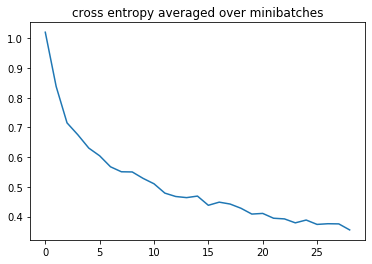

In [11]:
plt.title("cross entropy averaged over minibatches")
plt.plot(epoch_losses[1:])
plt.show()

In [12]:
torch.cuda.empty_cache()

## Test Metrics

In [13]:
test(net,device,test_loader)

tensor([[ -5.4556,  -2.1554,  -2.3969,  -6.6377,  -1.7049,  -0.1180,  -5.6274,
           6.4954, -10.3098,  -4.6112],
        [ -7.3893,  -9.4029,   2.8723,   1.8509,  -6.4098,   2.5109,  -3.7986,
          -3.7902,  -3.0524,  -4.4550],
        [ -6.0448,   9.9887,  -1.3209,  -5.2893,  -0.0474,   0.1870,  -4.7353,
          -0.4120,  -6.1911,  -5.5609],
        [  8.8308, -14.4343,  -7.6553, -12.2766,  -6.8848,  -4.6975,   0.7227,
          -1.5156,  -4.9078,   1.1313],
        [ -8.2751,  -5.6614,  -0.1978,  -7.5735,   1.9182,  -2.8398,  -5.4155,
           0.8922,  -6.2390,  -1.6757]], device='cuda:0') torch.Size([1000, 10])

 Average loss per epoch: 0.3502, Accuracy: 8877/10000 (89%)

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       980
         1.0       0.98      0.99      0.98      1135
         2.0       0.84      0.76      0.80      1032
         3.0       0.93      0.83      0.88      1010
         4.0       0.90      0.

## Saving

In [14]:
from utils import save_model

save_model("Cheb_max_orig_lattice", net)